# Primer uporabe vizualizacije za tabelarične podatke
V tem zvezku demonstriramo delovanje metode za raziskovanje poljubnih projekcij tabelaričnih podatkov.

In [1]:
import sys 
sys.path.append('..')

from lib.tab_exploration.tab_explorer import TabExplorer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import mlab
np.random.seed(1)
%matplotlib inline

Za demonstracijo uporabimo podatke o ljudeh s titanika. Množica vsebuje zvezne in diskretne atribute. Izbrali smo nasldenjo podmnožico atributov: (spol, starost, cena vstopnice, pristanišče vkrcanja, razred vozovnice ).

In [2]:
df = pd.read_csv('../data/titanic.csv')
df = (df.drop(['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
        .dropna(axis=0)
        .astype({'Pclass': object, 'Age': np.int32, 'Fare': np.float32}))
df.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,male,22,7.250000,S
1,1,female,38,71.283302,C
2,3,female,26,7.925000,S
3,1,female,35,53.099998,S
4,3,male,35,8.050000,S


Naslednjo funkcijo uporabimo za standardizacijo zveznih atributov

In [3]:
def standardize_continuous(df):
    df_numeric = df.select_dtypes(include=[np.number])
    df_other =  df.select_dtypes(exclude=[np.number])
    
    df_numeric = (df_numeric - df_numeric.mean())/df_numeric.std()
    return pd.concat([df_numeric, df_other], axis=1)

Za projekcijo podatkov uporabimo t-SNE, za razvrščanje pa DBSCAN.

In [4]:
tsne = TSNE()
X = pd.get_dummies(standardize_continuous(df)).values.astype(np.float32)
X_em = tsne.fit_transform(X)

In [5]:
dbscan = DBSCAN(eps=2.5)
clusters = dbscan.fit_predict(X_em)

Pridobljeno projekcijo in skupine lahko nato raziščemo.

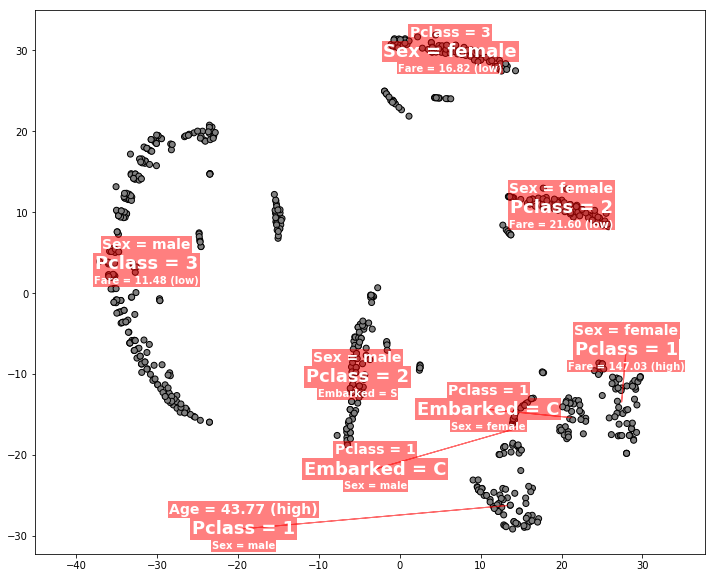

In [6]:
tab_explorer = TabExplorer(p_threshold=1e-2, min_cluster_size=30)
tab_explorer.fit(df, X_em, clusters)
fig, ax = tab_explorer.plot_static(avoid_overlaps=True)

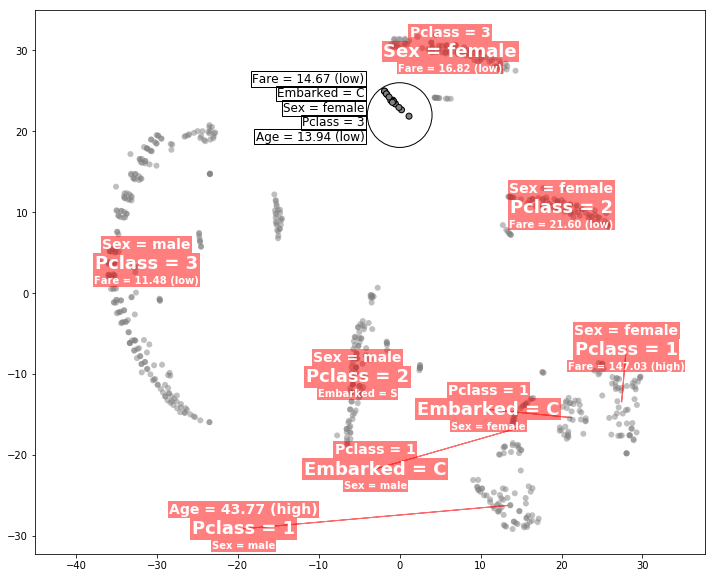

In [10]:
fig, ax = tab_explorer.plot_dynamic(0, 22, 4)
fig

<IPython.core.display.Javascript object>


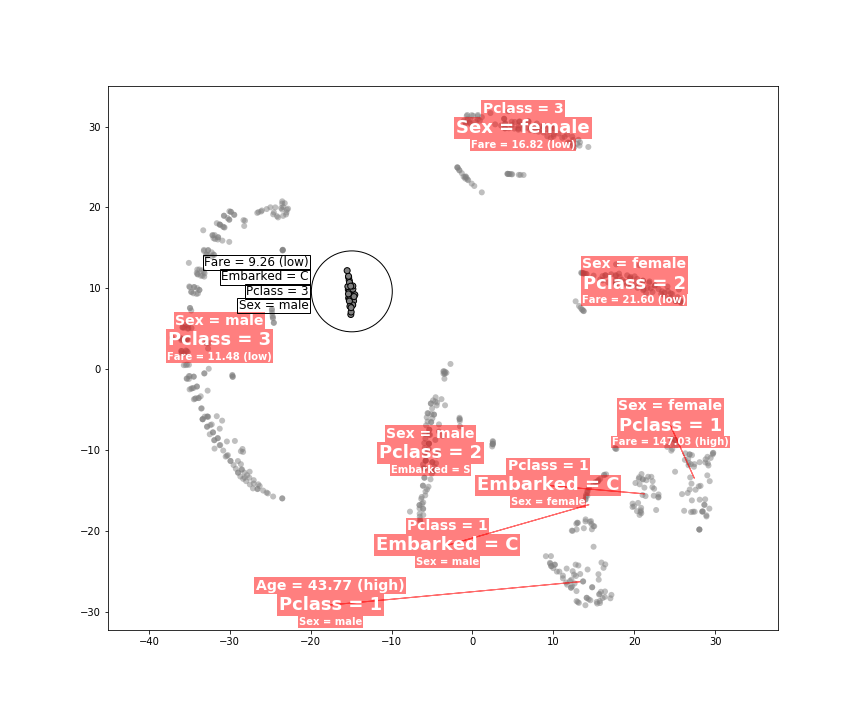

In [12]:
%matplotlib notebook

tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)
fig, ax = tab_explorer.plot_interactive()

## Primer izračuna p-vrednosti

Primer izračuna p-vrednosti za prvo (oranžno) skupino.

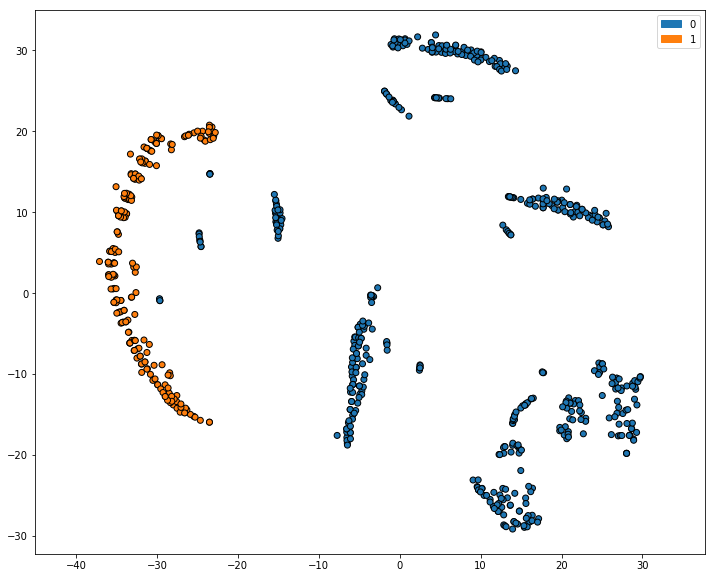

In [13]:
%matplotlib inline
is_first_cluster = clusters==0
fig,ax = tab_explorer.plot_static(classes=is_first_cluster.astype(np.int), plot_labels=False)

Najprej prodobimo nekaj osnovnih informacij o skupini.

In [14]:
df_dummies = pd.concat([pd.get_dummies(df[col]) if df[col].dtype==object else df[col] for col in df], axis=1,
                                     keys=df.columns)
first_cluster = df_dummies.loc[is_first_cluster]
not_first_cluster = df_dummies.loc[~is_first_cluster]


print("Total dataset size: {}".format(df_dummies.shape[0])) 
print("Cluster size: {}".format(first_cluster.shape[0])) 
print("Out-cluster size: {}".format(not_first_cluster.shape[0])) 

Total dataset size: 712
Cluster size: 212
Out-cluster size: 500


Za računanje p-vrednosti so ključne porazdelitve vrednosti v skupini, izven nje ter globalne porazdelitve.

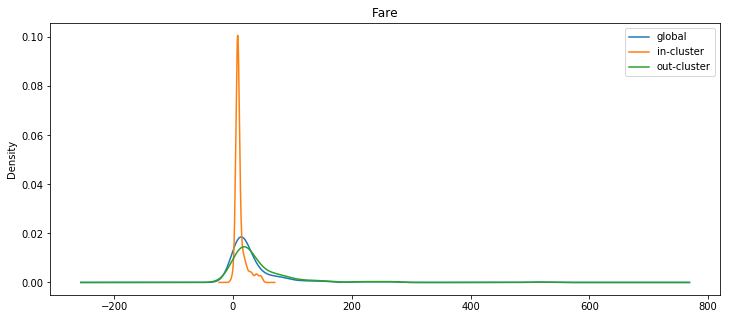

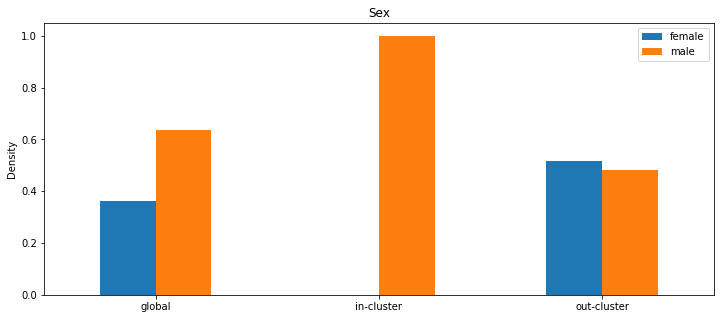

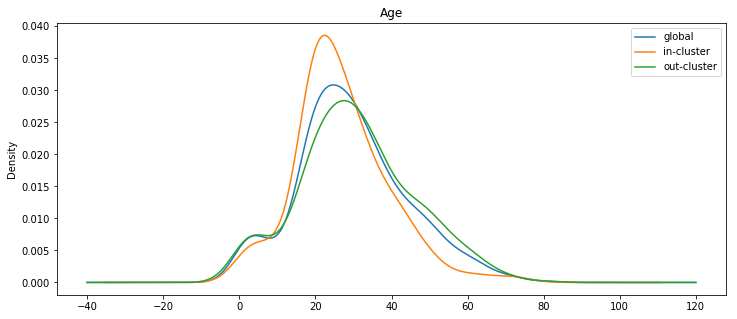

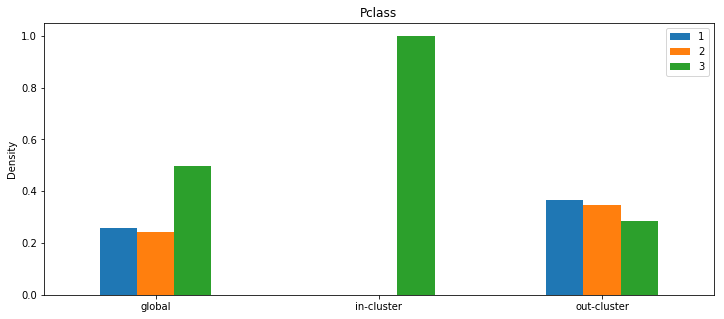

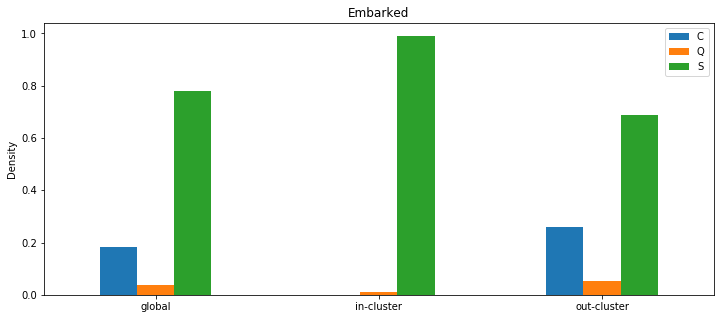

In [15]:
keys = ['global', 'in-cluster', 'out-cluster']
dfs = [df_dummies, first_cluster, not_first_cluster]

for c in set(df_dummies.columns.get_level_values(0)):
    if np.issubdtype(df[c].dtype, np.number):
        kind = 'kde'
        plot_df = pd.concat([df[c] for df in dfs], axis=1, keys=keys).T.reset_index(drop=True).T
        plot_df.columns = keys
    else:
        kind = 'bar'
        plot_df = pd.DataFrame([df[c].sum()/df[c].shape[0] for df in dfs],
                          index=keys)
    
    ax = plot_df.plot(kind=kind, rot=0, figsize=(12,5), title=c)
    ax.set_ylabel('Density')
    plt.show()

Opazimo, da so na teh podatkih porazdelitve v skupini precej čiste, sploh za diskretne atribute kjer imajo skoraj vsi pripadniki skupine enake vrednosti. Čiste porazdelitve dobimo tudi za veliko večino ostalih skupin, saj so podatki precej preprosti.

Če prikažemo še izračune p-vrednosti, opazimo da so te v skladu z našimi ugotovitvami. Poleg očitnih vrednosti za diskretne spremenljivke opazimo, da ima starost precej višjo p-vrednost od cene vozovnice. Tudi to je skladno z zgornjimi slikami saj je porazdelitev cene vozovnic v skupini precej bolj drugačna od te izven skupine (v primerjavi s starostjo).

In [16]:
numeric_p_values = tab_explorer._numeric_p_values(is_first_cluster)
discrete_p_values = tab_explorer._discrete_p_values(is_first_cluster)

p_values = pd.concat([numeric_p_values, discrete_p_values])
p_values

Age       Age       3.891809e-04
Fare      Fare      3.523315e-29
Pclass    1         1.000000e+00
          2         1.000000e+00
          3         5.725590e-85
Sex       female    1.000000e+00
          male      5.319390e-53
Embarked  C         1.000000e+00
          Q         9.994596e-01
          S         3.133331e-25
dtype: float64

Še vedno pa se zdi p-vrednost za starost glede na vizualno podobnost porazdelitve precej nizka. Ker t-test ne primerja porazdelitve vzorcev ampak porazdelitve vzorčnih povprečij (ob predpostavki normalnosti), izrišemo še te.

In [17]:
def plot_normals(mu_sig_lab):
    for mu, sigma, label in mu_sig_lab:
        x = np.linspace(mu - 5*sigma, mu + 5*sigma, 500)
        plt.plot(x, mlab.normpdf(x, mu, sigma), label=label)
        
    plt.legend()
    plt.show()


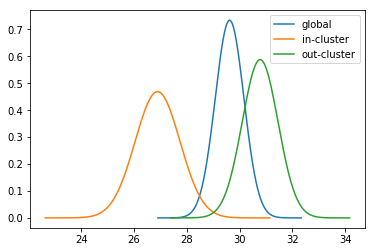

In [18]:
mu_sig_lab = [(df.Age.mean()[0], df.Age.std()[0]/np.sqrt(df.shape[0]), key) for key, df in zip(keys, dfs)]
plot_normals(mu_sig_lab)

Sedaj opazimo veliko razliko med porazdelitvama vzorčnih povprečij v skupini in izven nje. Nizka p-vrednost je torej smiselna.

## Problem večkratnih primerjanj

In [21]:
X = np.random.uniform(size=(1000,125))
clusters = np.random.randint(0,4, size=(1000,))
X_em = np.random.uniform(size=(1000, 2))
df = pd.DataFrame(X)
for i in range(25):
    df['d{}'.format(i)] = np.random.randint(0,4, size=(1000,)).astype(object)

Naključna množica podatkov brez uporabe FDR.

(<matplotlib.figure.Figure at 0x22b4abce2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b4ae4d2e8>)

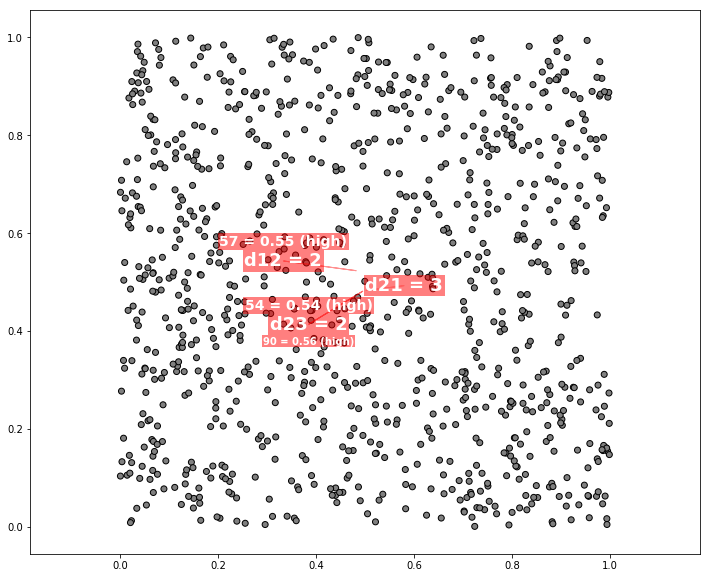

In [22]:
tab_explorer = TabExplorer(p_threshold=0.01, fdr_correction=False, representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)

Enaka naključna množica podatkov z uporabo FDR.

(<matplotlib.figure.Figure at 0x22b496d8780>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b4aedcc88>)

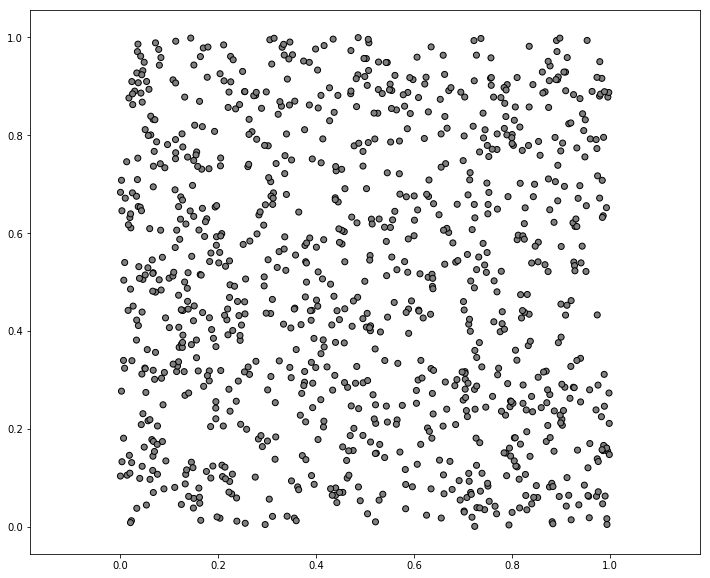

In [23]:
tab_explorer = TabExplorer(p_threshold=0.01, fdr_correction=True, representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True)

## Problem: signifikantnost ni nujno reprezentativnost

Generiranje umetne podatkovne množice

In [27]:
clusters = np.hstack((np.full(50, 1), np.full(50, 2)))
atr =  np.random.randint(0,2, size=(100,))
atr[-7:]  = 2

df = pd.DataFrame()
df['atr'] = atr.astype(object)
df['random'] = np.random.uniform(size=100)

X_em = np.array([[c + np.random.uniform(0, 0.2) -0.1*(a==2), np.random.uniform(0, 0.2)] for a,c in zip(atr, clusters)])

Brez uporabe reprezentativnega pragu

(<matplotlib.figure.Figure at 0x22b4a931a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b4ab12668>)

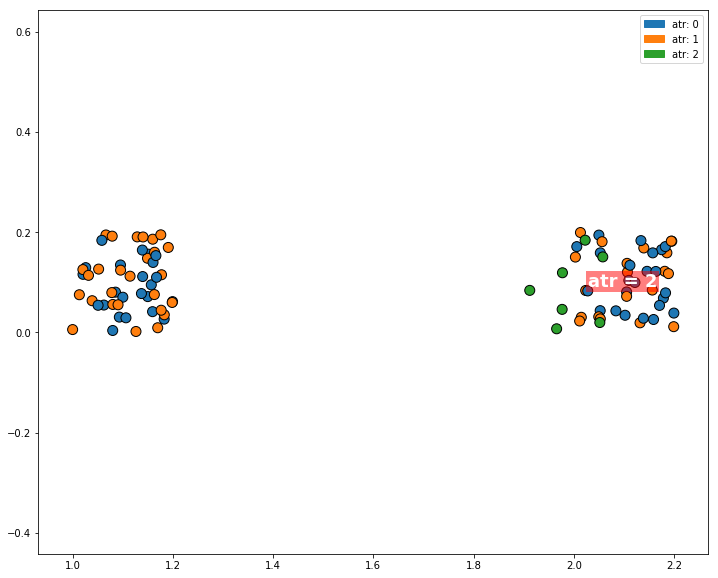

In [28]:
tab_explorer = TabExplorer(p_threshold=0.05, representative_threshold=0.0)
tab_explorer.fit(df, X_em, clusters)
labels = ['atr: '+ str(a) for a in atr]
tab_explorer.plot_static(avoid_overlaps=True, classes=labels, s=100)

Z uporabo reprezentativnega pragu

(<matplotlib.figure.Figure at 0x22b49d50320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22b4ab19d68>)

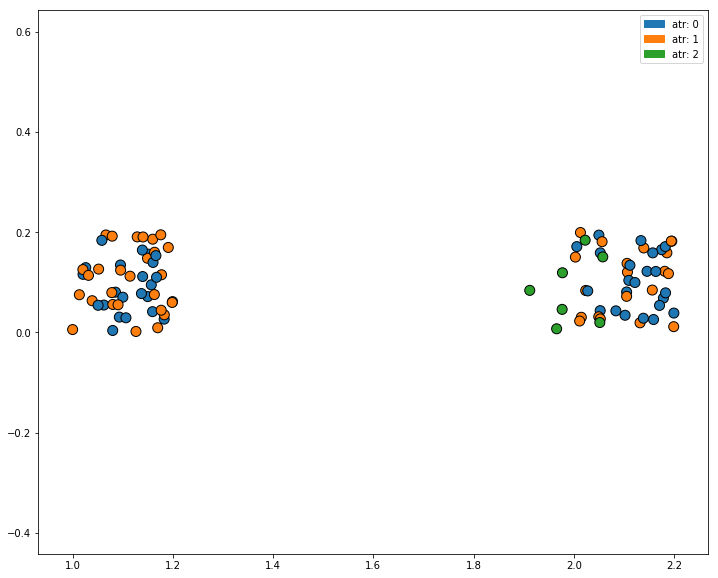

In [29]:
tab_explorer = TabExplorer(p_threshold=0.05, representative_threshold=0.5)
tab_explorer.fit(df, X_em, clusters)
tab_explorer.plot_static(avoid_overlaps=True, classes=labels, s=100)

Lahko bi ubrali tudi pristop kjer bi množili p-vrednosti z inverzi reprezentativnosti ampak bi s tem pokvarili interpretabilnost p-vrednosti.